In [27]:
# Standard imports
import itertools

# Package imports
import matplotlib.pyplot as plt
import matplotlib.lines
import numpy as np
from tqdm import tqdm

# Local imports
import Driving
from Driving import NavigationDemoLogParser, FrameParsers, driveUtilities
from Driving.NavigationDemoLogParser import NavigationDemoLogParser


Helper functions to load the data

In [28]:
def load_log_data(filenames):
    """
        Helper function for loading data.
        Returns a list of NavigationDemoLogParser objects corresponding to each
        file in filenames.  
    """
    # Load your simulation data using the NavigationDemoLogParser
    navigation_parsers = [NavigationDemoLogParser(filename, autoParse=True) for filename in filenames]
    return navigation_parsers

def load_scenario_label(filename):
    data = np.load(filename)
    timestamps = data['timestamps']
    labels = data['labels']
    return timestamps, labels

def load_centerlines(filename):
    data = np.load(filename)
    return data['lines']

Helper functions for handling trajectory data

In [29]:
def rotations_to_xy_angles(rotations):
    """A function to convert x, y, z rotation vectors to angles in the x, y plane
        
    @param rotations: a nx3 matrix with the columns corresponding to roll, pitch, and yaw
    in degrees. The yaw is referenced relative to North.
    
    @return: a vector of angles in radians where 0 is pointing right and increases counterclockwise. 
    """
    return rotations[:, 2] * np.pi / 180

def rotation_to_xy_angle(rotation):
    return rotation[2] * np.pi/180

# TODO: verify if this is really what we want for speed 
def velocity_and_heading_to_signed_speed(velocity, angle):
    """ Take in a 3-d velocity vector angle (in radians)
        and return the speed of the car along the direction of the angle. 
        Note that this is a signed speed, so it could be positive or negative.
    """
    return np.array([np.cos(angle), np.sin(angle)]) @ velocity[0:2]

def pad_or_truncate(some_list, target_len):
    return some_list[:target_len] + [0]*(target_len - len(some_list))

Going through the data in the parser and converting it into a matrix representing the trajectory. The states will be:
1. Ego position (2-d)
2. Ego angle (2-d angle)
3. Ego speed
4. Nearest k_vehicle vehicle positions (2-d)
5. nearest k_vehicle vehicle angle  
6. nearest k_vehicle speeds 
7. nearest k_pedestrian positions (2-d)
8. nearest k_pedestrian speeds
9. nearest centerline x1, y1, x2, y2



In [30]:
def select_closest(position, other_positions, other_rotations, other_speeds, k):
    """
         Select the k elements of other_positions, other_rotations, and other_speeds where 
         the element of other_positions is closest to position. 
    """
    distances = [np.linalg.norm(position - other_position) for other_position in other_positions]
    sorted_zipped = sorted(zip(distances, other_positions, other_rotations, other_speeds), key=lambda pair: pair[0])
    sorted_positions = [x for _, x, _, _ in sorted_zipped]
    sorted_rotations = [x for _, _, x, _ in sorted_zipped]
    sorted_speeds = [x for _, _, _, x in sorted_zipped]

    return sorted_positions[0:k], sorted_rotations[0:k], sorted_speeds[0:k]

# Projected point for finding the closest centerline
def projected_point(point, line_segment):
    """ 
        Take in an np array with 2 elements (point) and a line_segment, which is an array with two elements, a start point (np-array length 2) and end point (np-array length 2).
        Then return an np array with 2 elements that is the projected point
    """
    start_point = np.array(line_segment[0])
    end_point = np.array(line_segment[1])
    vec = end_point - start_point
    proj_point = vec @ (point - start_point) / (vec @ vec) * vec + start_point
    
    # Now, snap onto the end of the line segment if it's past it
    proj_point[0] = min(max(start_point[0], end_point[0]), proj_point[0]) # x = min(max(start_x, end_x))
    proj_point[0] = max(min(start_point[0], end_point[0]), proj_point[0])
    proj_point[1] = min(max(start_point[1], end_point[1]), proj_point[1])
    proj_point[1] = max(min(start_point[1], end_point[1]), proj_point[1])
    
    return proj_point

def projected_point_and_distance(point, line_segment):
    proj_point = projected_point(point, line_segment)
    return proj_point, np.linalg.norm(proj_point - point) 

In [55]:
def vehicle_index_to_col(index):
    return 4 + 4*index

def pedestrian_index_to_col(index, k_closest_vehicles):
    return 4 + 4*k_closest_vehicles + 4*index

def gather_controls(parser):
    # Set up the control matrix
    num_points = parser.playerPosition.shape[0]
    controls = np.zeros((num_points, 4))

    # Now pull out data on the controls
    throttles, brakes, steering_wheels, gears = parser.throttle, parser.brake, parser.steering, parser.gear

    # Fill in the matrix
    controls[:, 0] = np.array(throttles) - np.array(brakes)
    controls[:, 1] = steering_wheels
    controls[:, 2] = gears

    # check how often throttle and brake are both on 
    num_throttle_and_brake = np.sum(np.logical_and(throttles != 0, brakes != 0))
    print("Percent throttle and brake together: ", round(100 * num_throttle_and_brake / num_points, 4))

    return controls

def gather_states(parser, centerlines, k_closest_vehicles=3, k_closest_pedestrians=3):
    """

    """ 
    delta_T = 1/parser.FPS

    # Pull out all the data from the parser. start with the ego vehicle 
    positions = parser.playerPosition
    rotations = parser.playerRotation
    speeds = parser.speed

    # Now pull out data for the other vehicles 
    vehicle_position_map = parser.vehiclePosition 
    vehicle_rotation_map = parser.vehicleRotation      

    # Now pull out data for the pedestrians 
    pedestrian_position_map = parser.pedestrianPosition
    pedestrian_rotation_map = parser.pedestrianRotation

    # Create the state and control matrices
    num_points = positions.shape[0]
    states = np.zeros((num_points, 4 + 4*k_closest_vehicles + 4*k_closest_pedestrians + 4))

    # Fill in the state and control matrix indices that we can 
    states[:, 0:2] = positions[:, 0:2]
    states[:, 2] = rotations_to_xy_angles(rotations)
    states[:, 3] = speeds

    for i in tqdm(range(num_points)): # 1 to allow for speed estimate on vehicles
        position, rotation, speed = positions[i, 0:2], rotations[i, :], speeds[i]

        # Gather the vehicle states 
        vehicle_positions = []
        vehicle_rotations = []
        vehicle_velocities = [] # estimate these based off of previous moment 
        for vehicle in vehicle_position_map.keys():
            # Check if the vehicle exist now and at the previous step 
            vehicle_exists = not np.isnan(vehicle_position_map[vehicle][i, 0])
            vehicle_exists_previous = i > 0 and (not np.isnan(vehicle_position_map[vehicle][i-1, 0]))
            if vehicle_exists:
                vehicle_positions.append(vehicle_position_map[vehicle][i, 0:2])
                vehicle_rotations.append(vehicle_rotation_map[vehicle][i, :])

                # Estimate and add speed as well 
                if vehicle_exists_previous:
                    velocity_estimate = (vehicle_position_map[vehicle][i, :] - vehicle_position_map[vehicle][i-1, :]) / delta_T
                else:
                    velocity_estimate = np.array([0, 0])

                vehicle_velocities.append(velocity_estimate)
            
        # Select only the closest vehicles to retain 
        vehicle_positions, vehicle_rotations, vehicle_velocities = select_closest(position, vehicle_positions, vehicle_rotations, vehicle_velocities, k_closest_vehicles)
        
        # Gather the pedestrian states
        pedestrian_positions = [] 
        pedestrian_rotations = []
        pedestrian_velocities = []
        pedestrian_exists = []
        for pedestrian in pedestrian_position_map.keys():
            # Check if the pedestrian exists now and at the previous step 
            # Estimate velocity as 0 if this is their first tick. 
            pedestrian_exists = not np.isnan(pedestrian_position_map[pedestrian][i, 0])
            pedestrian_exists_previous = i > 0 and (not np.isnan(pedestrian_position_map[pedestrian][i-1, 0]))

            if pedestrian_exists:
                pedestrian_positions.append(pedestrian_position_map[pedestrian][i, 0:2])
                pedestrian_rotations.append(pedestrian_rotation_map[pedestrian][i, :])

                # Estimate and add speed as well 
                if pedestrian_exists_previous:
                    velocity_estimate = (pedestrian_position_map[pedestrian][i, :] - pedestrian_position_map[pedestrian][i-1, :]) / delta_T
                else:
                    velocity_estimate = np.array([0, 0])
                
                pedestrian_velocities.append(velocity_estimate)

        # Select only the closest pedestrians to retain 
        pedestrian_positions, pedestrian_rotations, pedestrian_velocities = select_closest(position, pedestrian_positions, pedestrian_rotations, pedestrian_velocities, k_closest_pedestrians)
        
        # Convert the rotations to angles in the 2-d plane
        vehicle_2d_angles = [rotation_to_xy_angle(vehicle_rotation) for vehicle_rotation in vehicle_rotations]
        pedestrian_2d_angles = [rotation_to_xy_angle(pedestrian_rotation) for pedestrian_rotation in pedestrian_rotations]

        # Convert the velocity vectors to signed speeds 
        vehicle_speeds = [velocity_and_heading_to_signed_speed(vehicle_velocity, vehicle_2d_angle) for vehicle_velocity, vehicle_2d_angle in zip(vehicle_velocities, vehicle_2d_angles)]
        pedestrian_speeds = [velocity_and_heading_to_signed_speed(pedestrian_velocity, pedestrian_2d_angle) for pedestrian_velocity, pedestrian_2d_angle in zip(pedestrian_velocities, pedestrian_2d_angles)]

        # pad the arrays with nans if there are not enough vehicles or pedestrians
        vehicle_positions_concatenated = np.array([]) if len(vehicle_positions) == 0 else np.concatenate(vehicle_positions)
        n_vehicles = len(vehicle_speeds)         
        if len(vehicle_speeds) < k_closest_vehicles:
            vehicle_positions_concatenated = np.pad(vehicle_positions_concatenated, (0, 2*(k_closest_vehicles - n_vehicles)), constant_values=(np.nan))
            vehicle_2d_angles = np.pad(vehicle_2d_angles, (0, k_closest_vehicles - n_vehicles), constant_values=(np.nan))
            vehicle_speeds = np.pad(vehicle_speeds, (0, k_closest_vehicles - n_vehicles), constant_values=(np.nan))

        pedestrian_positions_concatenated = np.array([]) if len(pedestrian_positions) == 0 else np.concatenate(pedestrian_positions)
        n_pedestrians = len(pedestrian_speeds)
        if len(pedestrian_speeds) < k_closest_pedestrians:
            pedestrian_positions_concatenated = np.pad(pedestrian_positions_concatenated, (0, 2*(k_closest_pedestrians - n_pedestrians)), constant_values=(np.nan))
            pedestrian_2d_angles = np.pad(pedestrian_2d_angles, (0, k_closest_pedestrians - n_pedestrians), constant_values=(np.nan))
            pedestrian_speeds = np.pad(pedestrian_speeds, (0, k_closest_pedestrians - n_pedestrians), constant_values=(np.nan))

        # Find the closest centerline
        projected_points = [projected_point(position, centerline) for centerline in centerlines]
        distances = [np.linalg.norm(position - projected_point) for projected_point in projected_points]
        closest_centerline_index = np.argmin(distances)


        # Fill in the state matrix appropriately
        for j in range(k_closest_vehicles):
            vehicle_col = vehicle_index_to_col(j) 
            states[i, vehicle_col:vehicle_col+2] = vehicle_positions_concatenated[j*2:(j+1)*2]
            states[i, vehicle_col+2] = vehicle_2d_angles[j]
            states[i, vehicle_col+3] = vehicle_speeds[j]
        
        for j in range(k_closest_pedestrians):
            pedestrian_col = pedestrian_index_to_col(j)
            states[i, pedestrian_col:pedestrian_col+2] = pedestrian_positions_concatenated[j*2:(j+1)*2]
            states[i, pedestrian_col+2] = pedestrian_2d_angles[j]
            states[i, pedestrian_col+3] = pedestrian_speeds[j]

        # states[i, 4:4+2*k_closest_vehicles] = vehicle_positions_concatenated
        # states[i, 4+2*k_closest_vehicles:4+3*k_closest_vehicles] = vehicle_2d_angles
        # states[i, 4+3*k_closest_vehicles:4+4*k_closest_vehicles] = vehicle_speeds

        # states[i, 4+4*k_closest_vehicles:4+4*k_closest_vehicles+2*k_closest_pedestrians] = pedestrian_positions_concatenated
        # states[i, 4+4*k_closest_vehicles+2*k_closest_pedestrians:4+4*k_closest_vehicles+3*k_closest_pedestrians] = pedestrian_2d_angles
        # states[i, 4+4*k_closest_vehicles+3*k_closest_pedestrians:4+4*k_closest_vehicles+4*k_closest_pedestrians] = pedestrian_speeds

        # Centerline
        states[i, 4+4*k_closest_vehicles+4*k_closest_pedestrians:4+4*k_closest_vehicles+4*k_closest_pedestrians+4] = np.concatenate(centerlines[closest_centerline_index]) 

    return states
    

Set the files we'd like to load for train, test, and validation. Then, load the trajectories.

In [49]:
# Specify the files for your train, validation, and test sets
train_runs = ["./Data/LogAndLabelData/20210126SP_13-52-24"]
validation_runs = ["./Data/LogAndLabelData/20210126SP_14-08-22"]
test_runs = ["./Data/LogAndLabelData/20210126SP_14-23-30"]

# Expand these into the full filenames for the log and label files
train_log_filenames = [train_run + "_positions.xml" for train_run in train_runs]
train_scenario_label_filenames = [train_run + "_scenario_labels.npz" for train_run in train_runs]

validation_log_filenames = [validation_run + "_positions.xml" for validation_run in validation_runs]
validation_scenario_label_filenames = [validation_run + "_scenario_labels.npz" for validation_run in validation_runs]

test_log_filenames = [test_run + "_positions.xml" for test_run in test_runs]
test_scenario_label_filenames = [test_run + "_scenario_labels.npz" for test_run in test_runs]

# Load the appropriate parsers for each of the files
train_parsers = load_log_data(train_log_filenames)
validation_parsers = load_log_data(validation_log_filenames)
test_parsers = load_log_data(test_log_filenames)

In [56]:
# Choose how many nearby vehicles and pedestrians to include in the state vector
k_closest_vehicles = 6
k_closest_pedestrians = 0
centerlines = load_centerlines("./Data/LogAndLabelData/map_centerlines.npz")

# Gather the state and control matrices for each of the files
train_trajectories = [(gather_states(parser, centerlines, k_closest_vehicles=k_closest_vehicles, k_closest_pedestrians=k_closest_pedestrians), gather_controls(parser)) for parser in train_parsers]
validation_trajectories = [(gather_states(parser, centerlines, k_closest_vehicles=k_closest_vehicles, k_closest_pedestrians=k_closest_pedestrians), gather_controls(parser)) for parser in validation_parsers]
test_trajectories = [(gather_states(parser, centerlines, k_closest_vehicles=k_closest_vehicles, k_closest_pedestrians=k_closest_pedestrians), gather_controls(parser)) for parser in test_parsers]

100%|██████████| 10916/10916 [00:40<00:00, 267.95it/s]


Percent throttle and brake together:  0.0092


100%|██████████| 10744/10744 [00:33<00:00, 323.32it/s]


Percent throttle and brake together:  0.0093


100%|██████████| 10867/10867 [00:35<00:00, 307.38it/s]

Percent throttle and brake together:  0.0092


In [41]:
# Also load the scenario labels 
train_labels = [load_scenario_label(filename) for filename in train_scenario_label_filenames]
validation_labels = [load_scenario_label(filename) for filename in validation_scenario_label_filenames]
test_labels = [load_scenario_label(filename) for filename in test_scenario_label_filenames]

Now, we'd like to pull out only the various straight segments from the trajectories. 

In [42]:
x = np.array([[1, 2, 3], [4, 2, 3], [4, 5, 6]])

end_point_set = {tuple(row[-2:]) for row in x}
num_each = [np.sum(x[:, -2:] == val) for val in end_point_set]
x[:, -2:] == (2, 3)

best_val = None 
best_count = -1
for val in end_point_set:
    count = np.sum(x[:, -2:] == val)
    if count > best_count:
        best_count = count
        best_val = val

print(best_val)
print(best_count)

(2, 3)
4


In [43]:
def video_time_to_log_sample(parser, video_time):
    """ 
        Given a video time, return the corresponding log sample. 
    """
    # The index will be given by the time elapsed since data started being captured
    # right now assuming parser data starts at the same time the video starts. 
    # scale the time by the data rate (parser.FPS)
    return int(video_time * parser.FPS)

def get_straight_demonstrations(parsers, trajectories, labels):
    """ 
        Given a list of trajectories, use the labels to pull out separate 
        sub-trajectories corresponding to each straight segment. 
    """
    sub_trajectories = []
    plt.figure()
    for (parser, trajectory, (timestamps, labels)) in zip(parsers, trajectories, labels):
        for (i, label) in enumerate(labels):
            label_to_color = {'straight': 'b', 'turning': 'r', 'dirt': 'g', 'transition': 'k'}
            #if label == 'straight':
            start_time = timestamps[i]
            end_time = timestamps[i+1]

            # Find the indices corresponding to the start and end times. 
            # note that these are start and end times from the video. 
            start_index = video_time_to_log_sample(parser, start_time)
            end_index = video_time_to_log_sample(parser, end_time)

            # index into the states and controls, and then append to our growing list 
            # of sub-trajectories if it's part of a straight trajectory
            sub_states = trajectory[0][start_index:end_index, :]
            sub_controls = trajectory[1][start_index:end_index, :]

            if label == 'straight':
                # We should have a single centerline for the whole trajectory. If that's not the case, 
                # then we can fill in with the majority centerline and that should be a good enough heuristic for us
                if not np.all(sub_states[:, -4:] == sub_states[0, -4:]):
                    print("not all demonstrations have same centerline")
                    # Find the most common centerline
                    centerline_set = {tuple(row[-4:]) for row in sub_states}
                    best_count = -1 
                    best_val = None
                    for val in centerline_set:
                        count = np.sum(sub_states[:, -4:] == val)
                        if count > best_count:
                            best_count = count
                            best_val = val
                        
                        print("counts for centerline: ", val, count)

                    # Fill in the centerline with the most common one
                    sub_states[:, -4:] = best_val
                    print("found most common centerline: ", best_val)

                sub_trajectories.append((sub_states, sub_controls))

            # Some extra plotting which helps us confirm our labeling
            plt.plot(sub_states[:, 0], sub_states[:, 1], color=label_to_color[label])
            plt.axis('equal')
            plt.xlim([-10000, 80000])
            plt.ylim([-20000, 70000])

            # add a legend describing the color to label mapping 
            legend_elements = [matplotlib.lines.Line2D([0], [0], color='b', lw=4, label='straight'),
                                 matplotlib.lines.Line2D([0], [0], color='r', lw=4, label='turning'),
                                    matplotlib.lines.Line2D([0], [0], color='g', lw=4, label='dirt'),
                                    matplotlib.lines.Line2D([0], [0], color='k', lw=4, label='transition')]
            plt.legend(handles=legend_elements, loc='upper right')

    return sub_trajectories

not all demonstrations have same centerline
counts for centerline:  (42719.0, 459.0, 42719.0, 53736.0) 5364
counts for centerline:  (43179.0, 7394.0, 48825.0, 7394.0) 8
found most common centerline:  (42719.0, 459.0, 42719.0, 53736.0)
not all demonstrations have same centerline
counts for centerline:  (16430.0, 25914.0, 16430.0, 53736.0) 1272
counts for centerline:  (8679.0, 32860.0, 15965.0, 32860.0) 20
found most common centerline:  (16430.0, 25914.0, 16430.0, 53736.0)
not all demonstrations have same centerline
counts for centerline:  (644.0, 0.0, 81685.0, 0.0) 1884
counts for centerline:  (6577.0, 459.0, 6572.0, 8472.0) 36
found most common centerline:  (644.0, 0.0, 81685.0, 0.0)
not all demonstrations have same centerline
counts for centerline:  (644.0, 41076.0, 15965.0, 41076.0) 12
counts for centerline:  (16430.0, 25914.0, 16430.0, 53736.0) 1276
found most common centerline:  (16430.0, 25914.0, 16430.0, 53736.0)


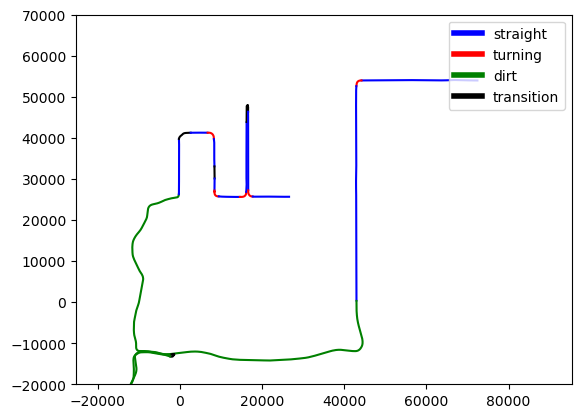

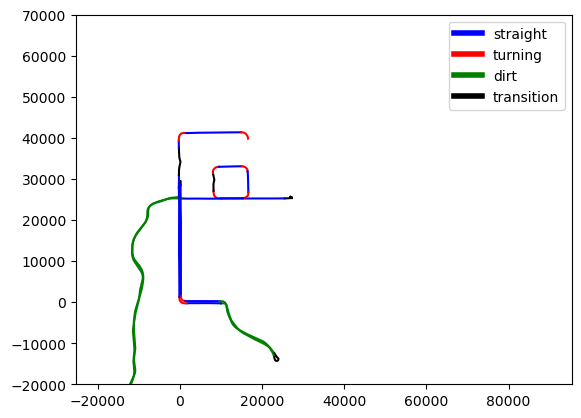

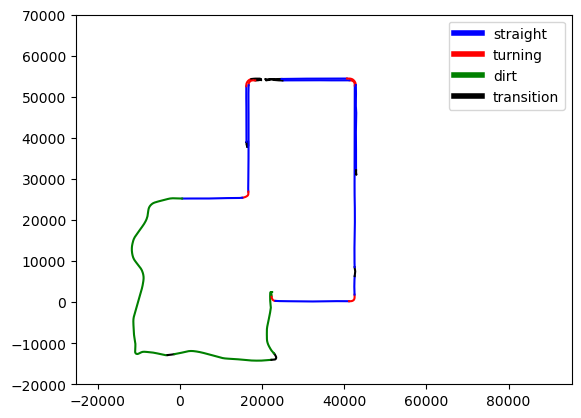

In [44]:
# Use the helper function above to load each straight segment of the trajectories as a separate 
# demonstration. it will return a list of trajectories, where trajectory is a states, controls pair. 
train_demonstrations = get_straight_demonstrations(train_parsers, train_trajectories, train_labels)
validation_demonstrations = get_straight_demonstrations(validation_parsers, validation_trajectories, validation_labels)
test_demonstrations = get_straight_demonstrations(test_parsers, test_trajectories, test_labels)

In [45]:
# Save the demonstrations to file
np.savez("./Data/Demonstrations/train_demonstrations_k_closest_vehicles="+str(k_closest_vehicles)+"_k_closest_pedestrians="+str(k_closest_pedestrians)+".npz", demonstrations=train_demonstrations)
np.savez("./Data/Demonstrations/validation_demonstrations_k_closest_vehicles="+str(k_closest_vehicles)+"_k_closest_pedestrians="+str(k_closest_pedestrians)+".npz", demonstrations=validation_demonstrations)
np.savez("./Data/Demonstrations/test_demonstrations_k_closest_vehicles="+str(k_closest_vehicles)+"_k_closest_pedestrians="+str(k_closest_pedestrians)+".npz", demonstrations=test_demonstrations)

In [39]:
# Test loading the files
loaded_demonstrations = np.load("./Data/Demonstrations/train_demonstrations_k_closest_vehicles=2_k_closest_pedestrians=0.npz", allow_pickle=True)['demonstrations']
# Test whether loaded_demonstrations is equal to test_demonstrations with a deep equality
# (i.e. all elements are equal)
all([np.array_equal(loaded_demonstrations[i][0], train_demonstrations[i][0]) for i in range(len(loaded_demonstrations))])
all([np.array_equal(loaded_demonstrations[i][1], train_demonstrations[i][1]) for i in range(len(loaded_demonstrations))])


True